This code produces month-to-month statistics of the interannual variability of ITCZ states in the observations, reanalyses, and CMIP6 model groups (top, intermediate, and bottom). To run this code without errors, the user must run "Interann_ITCZ_state_obs_reana_CMIP6_savenc.ipynb" first.

In [1]:
#Author: Alex Gonzalez
#Date: November 2025
#Paper: JGR-Atmospheres

Figure 11. Interannual variability of ITCZ states as a function of month of the year for IMERG
combined microwave and IR observations (MW+IR, solid black curves) and the median of reanalyses
(dashed black curves), top models (solid blue curves), intermediate models (solid gold curves), and
bottom models (solid red curves) as measured via (a–e, left panels) standard deviation (%) and
(f–j, right panels) coefficient of variation (unitless, interannual standard deviation divided by the
mean).
–

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from scipy import stats

from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import ImageGrid

In [3]:
region = 'EastPac'
region_str = 'East Pacific Ocean'

In [4]:
rain_thresh_str = '5.0mm'

In [5]:
figfolder = '/home/alex.gonzalez/CMIP6_ITCZ_state_project/figures/methods_paper/revision/'
figname = 'Interann_ITCZ_state_EastPac_groups.pdf'

In [6]:
dataset = ['IMERG','BCC-CSM2-MR',
            'CAMS-CSM1-0',
            'CESM2',
            'CESM2-WACCM',
            'CMCC-CM2-HR4',
            'CMCC-CM2-SR5',
            'CMCC-ESM2',
            'CNRM-CM6-1-HR',
            'E3SM-1-0',
            'E3SM-2-0',
            'E3SM-2-0-NARRM',
            'EC-Earth3',
            'EC-Earth3-AerChem',
            'EC-Earth3-CC',
            'EC-Earth3-Veg',
            'EC-Earth3-Veg-LR',
            'FGOALS-f3-L',
            'GFDL-CM4',
            'GFDL-ESM4',
            'HadGEM3-GC31-MM',
            'MPI-ESM1-2-HR',
            'MRI-ESM2-0',
            'NorESM2-MM',
            'SAM0-UNICON',
            'TaiESM1']

In [7]:
ndataset = len(dataset)
ndataset

26

In [8]:
# calculate Jan–Apr or mean anomalies for each year and for each ITCZ state and then std
# hypothesis is that the worst CMIP6 models underestimate interannual variability in ITCZ state 

In [42]:
group1 = ['CESM2-WACCM','NorESM2-MM']
group2 = ['CESM2', 'CMCC-CM2-SR5', 'CMCC-ESM2', 'E3SM-2-0', 'E3SM-2-0-NARRM',
       'FGOALS-f3-L', 'GFDL-CM4', 'HadGEM3-GC31-MM', 'MPI-ESM1-2-HR',
       'MRI-ESM2-0', 'SAM0-UNICON', 'TaiESM1']

#['BCC-CSM2-MR','CAMS-CSM1-0','CNRM-CM6-1-HR','E3SM-2-0', \
#            'E3SM-2-0-NARRM','FGOALS-f3-L','HadGEM3-GC31-MM','MPI-ESM1-2-HR']


group3 = ['BCC-CSM2-MR', 'CAMS-CSM1-0', 'CMCC-CM2-HR4', 'CNRM-CM6-1-HR',
       'E3SM-1-0', 'EC-Earth3', 'EC-Earth3-AerChem', 'EC-Earth3-CC',
       'EC-Earth3-Veg', 'EC-Earth3-Veg-LR', 'GFDL-ESM4']

#['CMCC-CM2-HR4','CMCC-CM2-SR5','CMCC-ESM2','E3SM-1-0','EC-Earth3',
#            'EC-Earth3-AerChem','EC-Earth3-CC','EC-Earth3-Veg','EC-Earth3-Veg-LR',
#            'GFDL-CM4','GFDL-ESM4','MRI-ESM2-0','SAM0-UNICON','TaiESM1']
ng1 = len(group1)
ng2 = len(group2)
ng3 = len(group3)

g1_name = 'Top models'
g2_name = 'Intermediate models'
g3_name = 'Bottom models'

In [10]:
# SST groups
#group1 = ['CESM2','CESM2-WACCM','NorESM2-MM']
#group2 = ['BCC-CSM2-MR','CNRM-CM6-1-HR','HadGEM3-GC31-MM','MPI-ESM1-2-HR']
# group3 = ['CMCC-CM2-HR4','CMCC-CM2-SR5','CMCC-ESM2','EC-Earth3',
#            'EC-Earth3-AerChem','EC-Earth3-CC','EC-Earth3-Veg','EC-Earth3-Veg-LR',
#            'GFDL-CM4','GFDL-ESM4','MRI-ESM2-0','SAM0-UNICON']

In [11]:
#nmodels = len(dataset)
nmon = 12
month = np.arange(1,nmon+1,1)

month_xr = xr.DataArray(month, coords=[month], dims=['month'])
datasets_xr = xr.DataArray(dataset, coords=[dataset], dims=['dataset'])
group1_xr = xr.DataArray(group1, coords=[group1], dims=['dataset'])
group2_xr = xr.DataArray(group2, coords=[group2], dims=['dataset'])
group3_xr = xr.DataArray(group3, coords=[group3], dims=['dataset'])

In [12]:
data_nI_interann = np.zeros((ndataset,nmon))
data_sI_interann = np.zeros((ndataset,nmon))
data_aI_interann = np.zeros((ndataset,nmon))
data_dI_interann = np.zeros((ndataset,nmon))
data_eI_interann = np.zeros((ndataset,nmon))

data_nI_mean = np.zeros((ndataset,nmon))
data_sI_mean = np.zeros((ndataset,nmon))
data_aI_mean = np.zeros((ndataset,nmon))
data_dI_mean = np.zeros((ndataset,nmon))
data_eI_mean = np.zeros((ndataset,nmon))

for jj in range(0,ndataset,1):
    if dataset[jj] == 'IMERG':
        yr0 = 1998
        yrf = 2024
        dri = '/srv/lss/IMERG_1deg/total_precip/'
        fni = dataset[jj]+'_ITCZ_st_daily_'+region+'_abs_thresh_'+rain_thresh_str
    else:
        yr0 = 1980
        yrf = 2014
        dri = '/srv/lss/CMIP6_precip_1deg/'+dataset[jj]+'/'
        fni = dataset[jj]+'_ITCZ_st_daily_'+region+'_abs_thresh'
        
    data = xr.open_dataset(dri+fni+'_frq_mon.nc', engine='netcdf4')

    # subset for years of interest before computing standard deviation
    frq_dITCZ_mon_subset = data['dITCZ'].sel(time=slice(str(yr0)+'-01',str(yrf)+'-12'))
    frq_nITCZ_mon_subset = data['nITCZ'].sel(time=slice(str(yr0)+'-01',str(yrf)+'-12'))
    frq_sITCZ_mon_subset = data['sITCZ'].sel(time=slice(str(yr0)+'-01',str(yrf)+'-12'))
    frq_aITCZ_mon_subset = data['aITCZ'].sel(time=slice(str(yr0)+'-01',str(yrf)+'-12'))
    frq_eITCZ_mon_subset = data['eITCZ'].sel(time=slice(str(yr0)+'-01',str(yrf)+'-12'))

    data_nI_interann[jj,:] = (frq_nITCZ_mon_subset*100).groupby(frq_nITCZ_mon_subset['time.month']).std(dim='time')
    data_sI_interann[jj,:] = (frq_sITCZ_mon_subset*100).groupby(frq_sITCZ_mon_subset['time.month']).std(dim='time')
    data_aI_interann[jj,:] = (frq_aITCZ_mon_subset*100).groupby(frq_aITCZ_mon_subset['time.month']).std(dim='time')
    data_dI_interann[jj,:] = (frq_dITCZ_mon_subset*100).groupby(frq_dITCZ_mon_subset['time.month']).std(dim='time')
    data_eI_interann[jj,:] = (frq_eITCZ_mon_subset*100).groupby(frq_eITCZ_mon_subset['time.month']).std(dim='time')
    
    data_nI_mean[jj,:] = (frq_nITCZ_mon_subset*100).groupby(frq_nITCZ_mon_subset['time.month']).mean(dim='time')
    data_sI_mean[jj,:] = (frq_sITCZ_mon_subset*100).groupby(frq_sITCZ_mon_subset['time.month']).mean(dim='time')
    data_aI_mean[jj,:] = (frq_aITCZ_mon_subset*100).groupby(frq_aITCZ_mon_subset['time.month']).mean(dim='time')
    data_dI_mean[jj,:] = (frq_dITCZ_mon_subset*100).groupby(frq_dITCZ_mon_subset['time.month']).mean(dim='time')
    data_eI_mean[jj,:] = (frq_eITCZ_mon_subset*100).groupby(frq_eITCZ_mon_subset['time.month']).mean(dim='time')

In [13]:
datasetr = ['IMERG','IMERG_mw','GPCP','ERA5','MERRA-2','JRA-3Q','CFSR']
folders_r = ['IMERG_1deg','IMERG_1deg','GPCP_daily','ERA5_1deg','MERRA-2','JRA-3Q','CFSR']
ndatasetr = len(folders_r)

In [14]:
region = 'EastPac'

data_nI_interann_r = np.zeros((ndatasetr,nmon))
data_sI_interann_r = np.zeros((ndatasetr,nmon))
data_aI_interann_r = np.zeros((ndatasetr,nmon))
data_dI_interann_r = np.zeros((ndatasetr,nmon))
data_eI_interann_r = np.zeros((ndatasetr,nmon))

data_nI_mean_r = np.zeros((ndatasetr,nmon))
data_sI_mean_r = np.zeros((ndatasetr,nmon))
data_aI_mean_r = np.zeros((ndatasetr,nmon))
data_dI_mean_r = np.zeros((ndatasetr,nmon))
data_eI_mean_r = np.zeros((ndatasetr,nmon))

for jj in range(0,ndatasetr,1):
    dri = '/srv/lss/'+folders_r[jj]+'/total_precip/'
    yr0 = 1998
    yrf = 2024
    fni = datasetr[jj]+'_ITCZ_st_daily_'+region+'_abs_thresh_'+rain_thresh_str
        
    data = xr.open_dataset(dri+fni+'_frq_mon.nc', engine='netcdf4')

    # subset for years of interest before computing standard deviation
    frq_dITCZ_mon_subset = data['dITCZ'].sel(time=slice(str(yr0)+'-01',str(yrf)+'-12'))
    frq_nITCZ_mon_subset = data['nITCZ'].sel(time=slice(str(yr0)+'-01',str(yrf)+'-12'))
    frq_sITCZ_mon_subset = data['sITCZ'].sel(time=slice(str(yr0)+'-01',str(yrf)+'-12'))
    frq_aITCZ_mon_subset = data['aITCZ'].sel(time=slice(str(yr0)+'-01',str(yrf)+'-12'))
    frq_eITCZ_mon_subset = data['eITCZ'].sel(time=slice(str(yr0)+'-01',str(yrf)+'-12'))

    data_nI_interann_r[jj,:] = (frq_nITCZ_mon_subset*100).groupby(frq_nITCZ_mon_subset['time.month']).std(dim='time')
    data_sI_interann_r[jj,:] = (frq_sITCZ_mon_subset*100).groupby(frq_sITCZ_mon_subset['time.month']).std(dim='time')
    data_aI_interann_r[jj,:] = (frq_aITCZ_mon_subset*100).groupby(frq_aITCZ_mon_subset['time.month']).std(dim='time')
    data_dI_interann_r[jj,:] = (frq_dITCZ_mon_subset*100).groupby(frq_dITCZ_mon_subset['time.month']).std(dim='time')
    data_eI_interann_r[jj,:] = (frq_eITCZ_mon_subset*100).groupby(frq_eITCZ_mon_subset['time.month']).std(dim='time')
    
    data_nI_mean_r[jj,:] = (frq_nITCZ_mon_subset*100).groupby(frq_nITCZ_mon_subset['time.month']).mean(dim='time')
    data_sI_mean_r[jj,:] = (frq_sITCZ_mon_subset*100).groupby(frq_sITCZ_mon_subset['time.month']).mean(dim='time')
    data_aI_mean_r[jj,:] = (frq_aITCZ_mon_subset*100).groupby(frq_aITCZ_mon_subset['time.month']).mean(dim='time')
    data_dI_mean_r[jj,:] = (frq_dITCZ_mon_subset*100).groupby(frq_dITCZ_mon_subset['time.month']).mean(dim='time')
    data_eI_mean_r[jj,:] = (frq_eITCZ_mon_subset*100).groupby(frq_eITCZ_mon_subset['time.month']).mean(dim='time')

In [15]:
# cf derivative – assume cyclic so that all derivatives are central finite diff.
def central_fd_dx(field_2d,x2):
    [nx1,nx2] = field_2d.shape
    # perform derivative on rightmost axis
    field = field_2d
    
    dfdx = np.zeros((nx1,nx2))
    dfdx[:,1:nx2-1] = (field[:,2:nx2] - field[:,0:nx2-2])/( (x2[:,2:nx2] - x2[:,0:nx2-2]) ) # interior derivatives
    
    # first longitude
    dfdx[:,0]        = (field[:,1] - field[:,0])/( (x2[:,1] - x2[:,0]) )
    # last longitude
    dfdx[:,nx2-1]   = (field[:,nx2-1] - field[:,nx2-2])/(x2[:,nx2-1] - x2[:,nx2-2])
    dfdx_final = dfdx
    return dfdx_final

In [16]:
data_nI_interann_xr = xr.DataArray(data_nI_interann, coords=[dataset,month], dims=['dataset','month'])
data_sI_interann_xr = xr.DataArray(data_sI_interann, coords=[dataset,month], dims=['dataset','month'])
data_aI_interann_xr = xr.DataArray(data_aI_interann, coords=[dataset,month], dims=['dataset','month'])
data_dI_interann_xr = xr.DataArray(data_dI_interann, coords=[dataset,month], dims=['dataset','month'])
data_eI_interann_xr = xr.DataArray(data_eI_interann, coords=[dataset,month], dims=['dataset','month'])

In [17]:
data_nI_mean_xr = xr.DataArray(data_nI_mean, coords=[dataset,month], dims=['dataset','month'])
data_sI_mean_xr = xr.DataArray(data_sI_mean, coords=[dataset,month], dims=['dataset','month'])
data_aI_mean_xr = xr.DataArray(data_aI_mean, coords=[dataset,month], dims=['dataset','month'])
data_dI_mean_xr = xr.DataArray(data_dI_mean, coords=[dataset,month], dims=['dataset','month'])
data_eI_mean_xr = xr.DataArray(data_eI_mean, coords=[dataset,month], dims=['dataset','month'])

In [18]:
data_nI_interann_cv_xr = data_nI_interann_xr/data_nI_mean
data_sI_interann_cv_xr = data_sI_interann_xr/data_sI_mean
data_aI_interann_cv_xr = data_aI_interann_xr/data_aI_mean
data_dI_interann_cv_xr = data_dI_interann_xr/data_dI_mean
data_eI_interann_cv_xr = data_eI_interann_xr/data_eI_mean

In [19]:
# since the mean and std dev approach sometimes are both zero, we will have to use L'hopital's Rule
# first just compute d(stdv)/d(mean)
#----------------------------------------------CMIP6----------------------------------------------#
d_dm_nI_cv_xr = central_fd_dx(data_nI_interann,data_nI_mean) + data_nI_interann_xr*0
d_dm_sI_cv_xr = central_fd_dx(data_sI_interann,data_sI_mean) + data_sI_interann_xr*0
d_dm_dI_cv_xr = central_fd_dx(data_dI_interann,data_dI_mean) + data_dI_interann_xr*0
d_dm_aI_cv_xr = central_fd_dx(data_aI_interann,data_aI_mean) + data_aI_interann_xr*0
d_dm_eI_cv_xr = central_fd_dx(data_eI_interann,data_eI_mean) + data_eI_interann_xr*0

/tmp/ipykernel_123382/3045417500.py:9: RuntimeWarning: divide by zero encountered in divide
  dfdx[:,1:nx2-1] = (field[:,2:nx2] - field[:,0:nx2-2])/( (x2[:,2:nx2] - x2[:,0:nx2-2]) ) # interior derivatives
/tmp/ipykernel_123382/3045417500.py:9: RuntimeWarning: invalid value encountered in divide
  dfdx[:,1:nx2-1] = (field[:,2:nx2] - field[:,0:nx2-2])/( (x2[:,2:nx2] - x2[:,0:nx2-2]) ) # interior derivatives
/tmp/ipykernel_123382/3045417500.py:14: RuntimeWarning: invalid value encountered in divide
  dfdx[:,nx2-1]   = (field[:,nx2-1] - field[:,nx2-2])/(x2[:,nx2-1] - x2[:,nx2-2])


In [27]:
#-----------------nITCZ-----------------#
# when the mean equals zero
cond1 = data_nI_interann_xr==0
# when the st dev equals zero
cond2 = data_nI_mean_xr==0
data_nI_cv = xr.where(cond1 & cond2,d_dm_nI_cv_xr,data_nI_interann_cv_xr)
# where d(stdv)/d(mean) < 0, set to d(stdv)/d(mean)=0
cond3 = data_nI_cv < 0
data_nI_cv_final = xr.where(cond3,0,data_nI_cv)

#-----------------sITCZ-----------------#
cond1 = data_sI_interann_xr==0
cond2 = data_sI_mean_xr==0
data_sI_cv = xr.where(cond1 & cond2,d_dm_sI_cv_xr,data_sI_interann_cv_xr)
cond3 = data_sI_cv < 0
data_sI_cv_final = xr.where(cond3,0,data_sI_cv)

#-----------------dITCZ-----------------#
cond1 = data_dI_interann_xr==0
cond2 = data_dI_mean_xr==0
data_dI_cv = xr.where(cond1 & cond2,d_dm_dI_cv_xr,data_dI_interann_cv_xr)
cond3 = data_dI_cv < 0
data_dI_cv_final = xr.where(cond3,0,data_dI_cv)

#-----------------aITCZ-----------------#
cond1 = data_aI_interann_xr==0
cond2 = data_aI_mean_xr==0
data_aI_cv = xr.where(cond1 & cond2,d_dm_aI_cv_xr,data_aI_interann_cv_xr)
cond3 = data_aI_cv < 0
data_aI_cv_final = xr.where(cond3,0,data_aI_cv)

#-----------------eITCZ-----------------#
cond1 = data_eI_interann_xr==0
cond2 = data_eI_mean_xr==0
data_eI_cv = xr.where(cond1 & cond2,d_dm_eI_cv_xr,data_eI_interann_cv_xr)
cond3 = data_eI_cv < 0
data_eI_cv_final = xr.where(cond3,0,data_eI_cv)

In [28]:
data_nI_interannr_xr = xr.DataArray(data_nI_interann_r, coords=[datasetr,month], dims=['dataset','month'])
data_sI_interannr_xr = xr.DataArray(data_sI_interann_r, coords=[datasetr,month], dims=['dataset','month'])
data_aI_interannr_xr = xr.DataArray(data_aI_interann_r, coords=[datasetr,month], dims=['dataset','month'])
data_dI_interannr_xr = xr.DataArray(data_dI_interann_r, coords=[datasetr,month], dims=['dataset','month'])
data_eI_interannr_xr = xr.DataArray(data_eI_interann_r, coords=[datasetr,month], dims=['dataset','month'])

In [29]:
data_nI_meanr_xr = xr.DataArray(data_nI_mean_r, coords=[datasetr,month], dims=['dataset','month'])
data_sI_meanr_xr = xr.DataArray(data_sI_mean_r, coords=[datasetr,month], dims=['dataset','month'])
data_aI_meanr_xr = xr.DataArray(data_aI_mean_r, coords=[datasetr,month], dims=['dataset','month'])
data_dI_meanr_xr = xr.DataArray(data_dI_mean_r, coords=[datasetr,month], dims=['dataset','month'])
data_eI_meanr_xr = xr.DataArray(data_eI_mean_r, coords=[datasetr,month], dims=['dataset','month'])

In [30]:
data_nI_interannr_cv_xr = data_nI_interannr_xr/data_nI_mean_r
data_sI_interannr_cv_xr = data_sI_interannr_xr/data_sI_mean_r
data_aI_interannr_cv_xr = data_aI_interannr_xr/data_aI_mean_r
data_dI_interannr_cv_xr = data_dI_interannr_xr/data_dI_mean_r
data_eI_interannr_cv_xr = data_eI_interannr_xr/data_eI_mean_r

In [31]:
# since the mean and std dev approach sometimes are both zero, we will have to use L'hopital's Rule
# first just compute d(stdv)/d(mean)
#----------------------------------------------OBS/REANA----------------------------------------------#
d_dm_nI_cv_xr_r = central_fd_dx(data_nI_interann_r,data_nI_mean_r) + data_nI_interannr_xr*0
d_dm_sI_cv_xr_r = central_fd_dx(data_sI_interann_r,data_sI_mean_r) + data_nI_interannr_xr*0
d_dm_dI_cv_xr_r = central_fd_dx(data_dI_interann_r,data_dI_mean_r) + data_nI_interannr_xr*0
d_dm_aI_cv_xr_r = central_fd_dx(data_aI_interann_r,data_aI_mean_r) + data_nI_interannr_xr*0
d_dm_eI_cv_xr_r = central_fd_dx(data_eI_interann_r,data_eI_mean_r) + data_nI_interannr_xr*0

/tmp/ipykernel_123382/3045417500.py:9: RuntimeWarning: invalid value encountered in divide
  dfdx[:,1:nx2-1] = (field[:,2:nx2] - field[:,0:nx2-2])/( (x2[:,2:nx2] - x2[:,0:nx2-2]) ) # interior derivatives
/tmp/ipykernel_123382/3045417500.py:14: RuntimeWarning: invalid value encountered in divide
  dfdx[:,nx2-1]   = (field[:,nx2-1] - field[:,nx2-2])/(x2[:,nx2-1] - x2[:,nx2-2])


In [25]:
cond1 = data_nI_interannr_xr==0
cond2 = data_nI_meanr_xr==0
data_nI_cv_r = xr.where(cond1 & cond2,d_dm_nI_cv_xr_r,data_nI_interannr_cv_xr)
cond3 = data_nI_cv_r < 0
data_nI_cv_final_r = xr.where(cond3,0,data_nI_cv_r)

cond1 = data_sI_interannr_xr==0
cond2 = data_sI_meanr_xr==0
data_sI_cv_r = xr.where(cond1 & cond2,d_dm_sI_cv_xr_r,data_sI_interannr_cv_xr)
cond3 = data_sI_cv_r < 0
data_sI_cv_final_r = xr.where(cond3,0,data_sI_cv_r)

cond1 = data_aI_interannr_xr==0
cond2 = data_aI_meanr_xr==0
data_aI_cv_r = xr.where(cond1 & cond2,d_dm_aI_cv_xr_r,data_aI_interannr_cv_xr)
cond3 = data_aI_cv_r < 0
data_aI_cv_final_r = xr.where(cond3,0,data_aI_cv_r)

cond1 = data_dI_interannr_xr==0
cond2 = data_dI_meanr_xr==0
data_dI_cv_r = xr.where(cond1 & cond2,d_dm_dI_cv_xr_r,data_dI_interannr_cv_xr)
cond3 = data_dI_cv_r < 0
data_dI_cv_final_r = xr.where(cond3,0,data_dI_cv_r)

cond1 = data_eI_interannr_xr==0
cond2 = data_eI_meanr_xr==0
data_eI_cv_r = xr.where(cond1 & cond2,d_dm_eI_cv_xr_r,data_eI_interannr_cv_xr)
cond3 = data_eI_cv_r < 0
data_eI_cv_final_r = xr.where(cond3,0,data_eI_cv_r)

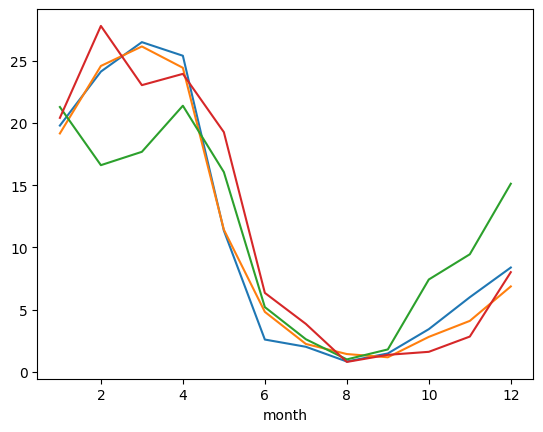

In [36]:
data_nI_interannr_xr.sel(dataset='IMERG').plot()
data_nI_interannr_xr.sel(dataset='IMERG_mw').plot()
data_nI_interannr_xr.sel(dataset='GPCP').plot()
data_nI_interannr_xr.sel(dataset=['ERA5','MERRA-2','JRA-3Q','CFSR']).median(dim=('dataset')).plot()

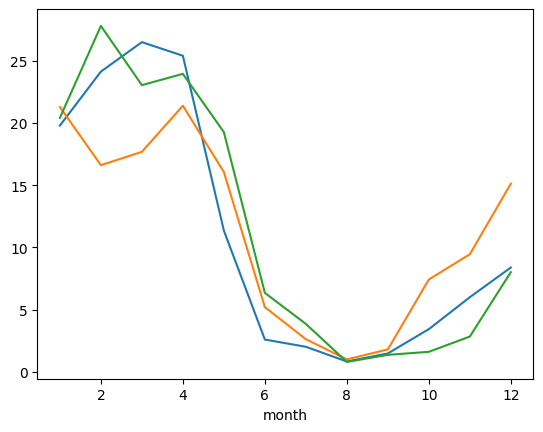

In [39]:
data_nI_interannr_xr.sel(dataset='IMERG').plot()
data_nI_interannr_xr.sel(dataset='GPCP').plot()
data_nI_interannr_xr.sel(dataset=['ERA5','MERRA-2','JRA-3Q','CFSR']).median(dim=('dataset')).plot()

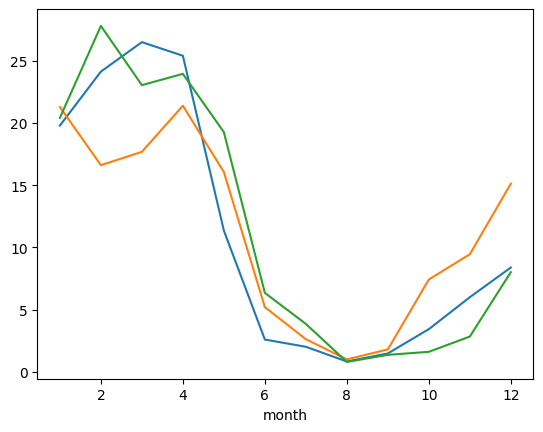

In [41]:
data_nI_interannr_xr.sel(dataset='IMERG').plot()
data_nI_interannr_xr.sel(dataset='GPCP').plot()
data_nI_interannr_xr.sel(dataset=['ERA5','MERRA-2','JRA-3Q','CFSR']).median(dim=('dataset')).plot()

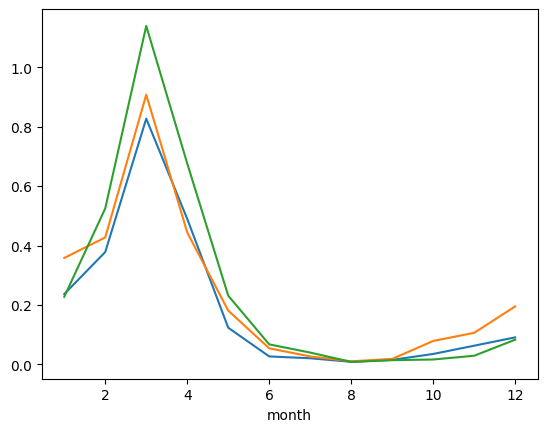

In [42]:
data_nI_interannr_cv_xr.sel(dataset='IMERG').plot()
data_nI_interannr_cv_xr.sel(dataset='GPCP').plot()
data_nI_interannr_cv_xr.sel(dataset=['ERA5','MERRA-2','JRA-3Q','CFSR']).median(dim=('dataset')).plot()

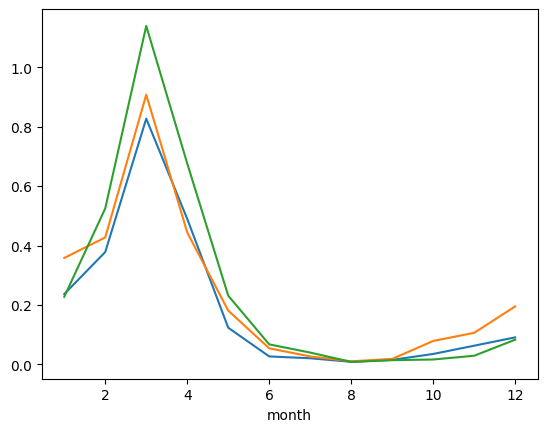

In [32]:
data_nI_interannr_cv_xr.sel(dataset='IMERG').plot()
data_nI_interannr_cv_xr.sel(dataset='GPCP').plot()
data_nI_interannr_cv_xr.sel(dataset=['ERA5','MERRA-2','JRA-3Q','CFSR']).median(dim=('dataset')).plot()

In [33]:
mon_str = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

In [34]:
rean_names = ['ERA5','MERRA-2','JRA-3Q','CFSR']

In [35]:
data_nI_interannr_xr

<xarray.DataArray (dataset: 7, month: 12)>
array([[19.78661996, 24.11898837, 26.48344278, 25.39131333, 11.35697456,
         2.60724841,  2.02754633,  0.84481097,  1.49173407,  3.44202157,
         6.00512914,  8.39006951],
       [19.15318942, 24.57094596, 26.13676389, 24.42448368, 11.4296399 ,
         4.82903882,  2.25423683,  1.44361362,  1.18415593,  2.82222504,
         4.10575041,  6.87215009],
       [21.2758225 , 16.60717486, 17.678969  , 21.37906621, 16.05407602,
         5.21157307,  2.63385994,  1.01377316,  1.81443685,  7.42857422,
         9.45333534, 15.11663264],
       [20.04891466, 27.22324201, 25.47297704, 23.90602952, 13.75563963,
         2.53612822,  1.44361362,  0.60920185,  0.        ,  0.84481097,
         1.65634665,  3.80821444],
       [27.70825436, 26.18421351, 29.50168932, 28.38593519, 22.93595658,
        18.95132101, 18.88752482, 18.87769761, 18.97221996, 23.45655347,
        20.18735594, 23.65289676],
       [20.76242198, 30.23307141, 20.59052352, 23.96842917, 19.47394653,
         4.56623259,  2.32284613,  0.        ,  0.        ,  1.34109584,
         2.91629921,  7.34548442],
       [19.90314401, 28.34808516, 19.41301345, 22.99148633, 19.04332104,
         8.13878999,  5.4067902 ,  1.01377316,  2.76057775,  1.90410722,
         2.77709182,  8.68800906]])
Coordinates:
  * dataset  (dataset) <U8 'IMERG' 'IMERG_mw' 'GPCP' ... 'JRA-3Q' 'CFSR'
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [36]:
prc_nITCZ_reana = data_nI_interannr_xr.sel(dataset=rean_names).median(dim=('dataset'))
prc_sITCZ_reana = data_sI_interannr_xr.sel(dataset=rean_names).median(dim=('dataset'))
prc_aITCZ_reana = data_aI_interannr_xr.sel(dataset=rean_names).median(dim=('dataset'))
prc_dITCZ_reana = data_dI_interannr_xr.sel(dataset=rean_names).median(dim=('dataset'))
prc_eITCZ_reana = data_eI_interannr_xr.sel(dataset=rean_names).median(dim=('dataset'))

In [37]:
prc_nITCZ_reana_cv = data_nI_cv_final_r.sel(dataset=rean_names).median(dim=('dataset'))
prc_sITCZ_reana_cv = data_sI_cv_final_r.sel(dataset=rean_names).median(dim=('dataset'))
prc_aITCZ_reana_cv = data_aI_cv_final_r.sel(dataset=rean_names).median(dim=('dataset'))
prc_dITCZ_reana_cv = data_dI_cv_final_r.sel(dataset=rean_names).median(dim=('dataset'))
prc_eITCZ_reana_cv = data_eI_cv_final_r.sel(dataset=rean_names).median(dim=('dataset'))

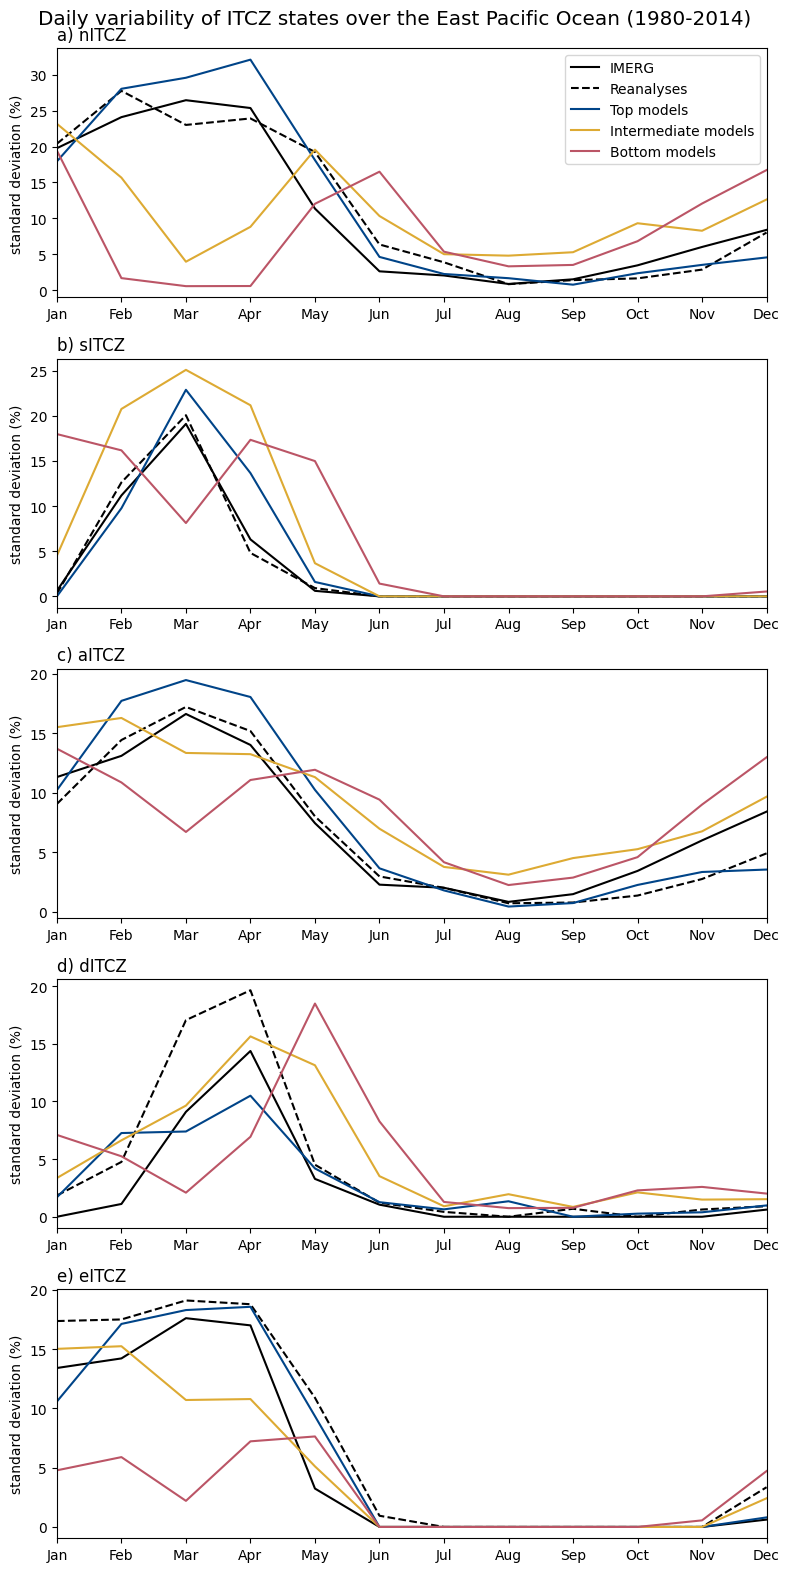

In [45]:
npan = 5

# all of the sizes are double the size they'll be in the paper 
fig = plt.figure(figsize=(8,16), tight_layout='true')
fig.suptitle(r'Daily variability of ITCZ states over the '+region_str+' (1980-2014)',fontsize='x-large')
for jj in range(0,npan,1):
    ax = fig.add_subplot(npan,1,jj+1)
    #axs.set_ylim(0,105)

    if jj == 0:
        # plot violin plot
        ax1 = ax.plot(month,data_nI_interann_xr.sel(dataset='IMERG'),color='k',label='IMERG')
        ax2 = ax.plot(month,prc_nITCZ_reana,color='k',linestyle='--',label='Reanalyses')
        ax3 = ax.plot(month,data_nI_interann_xr.sel(dataset=group1_xr).median(dim=('dataset')), color='#004488',label=g1_name)
        ax4 = ax.plot(month,data_nI_interann_xr.sel(dataset=group2_xr).median(dim=('dataset')), color='#DDAA33',label=g2_name)
        ax5 = ax.plot(month,data_nI_interann_xr.sel(dataset=group3_xr).median(dim=('dataset')), color='#BB5566',label=g3_name)

        plt.legend(loc='upper right')
        plt.ylabel('standard deviation (%)')
        #plt.ylim(-3,37)
        ax.set_title('a) nITCZ', loc='left')
    if jj == 1:
        # plot violin plot
        ax1 = ax.plot(month,data_sI_interann_xr.sel(dataset='IMERG'),color='k',label='IMERG')
        ax2 = ax.plot(month,prc_sITCZ_reana,color='k',linestyle='--',label='Reanalysis')
        ax3 = ax.plot(month,data_sI_interann_xr.sel(dataset=group1_xr).median(dim=('dataset')), color='#004488',label=g1_name)
        ax4 = ax.plot(month,data_sI_interann_xr.sel(dataset=group2_xr).median(dim=('dataset')), color='#DDAA33',label=g2_name)
        ax5 = ax.plot(month,data_sI_interann_xr.sel(dataset=group3_xr).median(dim=('dataset')), color='#BB5566',label=g3_name)

        #plt.legend(loc='upper right')
        plt.ylabel('standard deviation (%)')
        #plt.ylim(-3,37)
        ax.set_title('b) sITCZ', loc='left')
    if jj == 2:
        # plot violin plot
        ax1 = ax.plot(month,data_aI_interann_xr.sel(dataset='IMERG'),color='k',label='IMERG')
        ax2 = ax.plot(month,prc_aITCZ_reana,color='k',linestyle='--',label='Reanalysis')
        ax3 = ax.plot(month,data_aI_interann_xr.sel(dataset=group1_xr).median(dim=('dataset')), color='#004488',label=g1_name)
        ax4 = ax.plot(month,data_aI_interann_xr.sel(dataset=group2_xr).median(dim=('dataset')), color='#DDAA33',label=g2_name)
        ax5 = ax.plot(month,data_aI_interann_xr.sel(dataset=group3_xr).median(dim=('dataset')), color='#BB5566',label=g3_name)

        #plt.legend(loc='upper right')
        plt.ylabel('standard deviation (%)')
        #plt.ylim(-3,37)
        ax.set_title('c) aITCZ', loc='left')    
    if jj == 3:
        # plot violin plot
        ax1 = ax.plot(month,data_dI_interann_xr.sel(dataset='IMERG'),color='k',label='IMERG')
        ax2 = ax.plot(month,prc_dITCZ_reana,color='k',linestyle='--',label='Reanalysis')
        ax3 = ax.plot(month,data_dI_interann_xr.sel(dataset=group1_xr).median(dim=('dataset')), color='#004488',label=g1_name)
        ax4 = ax.plot(month,data_dI_interann_xr.sel(dataset=group2_xr).median(dim=('dataset')), color='#DDAA33',label=g2_name)
        ax5 = ax.plot(month,data_dI_interann_xr.sel(dataset=group3_xr).median(dim=('dataset')), color='#BB5566',label=g3_name)

        #plt.legend(loc='upper right')
        plt.ylabel('standard deviation (%)')
        #plt.ylim(-3,37)
        ax.set_title('d) dITCZ', loc='left')
    if jj == 4:
        # plot violin plot
        ax1 = ax.plot(month,data_eI_interann_xr.sel(dataset='IMERG'),color='k',label='IMERG')
        ax2 = ax.plot(month,prc_eITCZ_reana,color='k',linestyle='--',label='Reanalysis')
        ax3 = ax.plot(month,data_eI_interann_xr.sel(dataset=group1_xr).median(dim=('dataset')), color='#004488',label=g1_name)
        ax4 = ax.plot(month,data_eI_interann_xr.sel(dataset=group2_xr).median(dim=('dataset')), color='#DDAA33',label=g2_name)
        ax5 = ax.plot(month,data_eI_interann_xr.sel(dataset=group3_xr).median(dim=('dataset')), color='#BB5566',label=g3_name)

        #plt.legend(loc='upper right')
        plt.ylabel('standard deviation (%)')
        #plt.ylim(-3,37)
        ax.set_title('e) eITCZ', loc='left')
    #ax.set_title('Jan-May mean error = '+str(prc_anom_abs_median_fmt[jj])+'%', loc='right')
    plt.xlim(1,12)
    #plt.xlabel('month')
    ax.set_xticks(month,labels=mon_str)
    

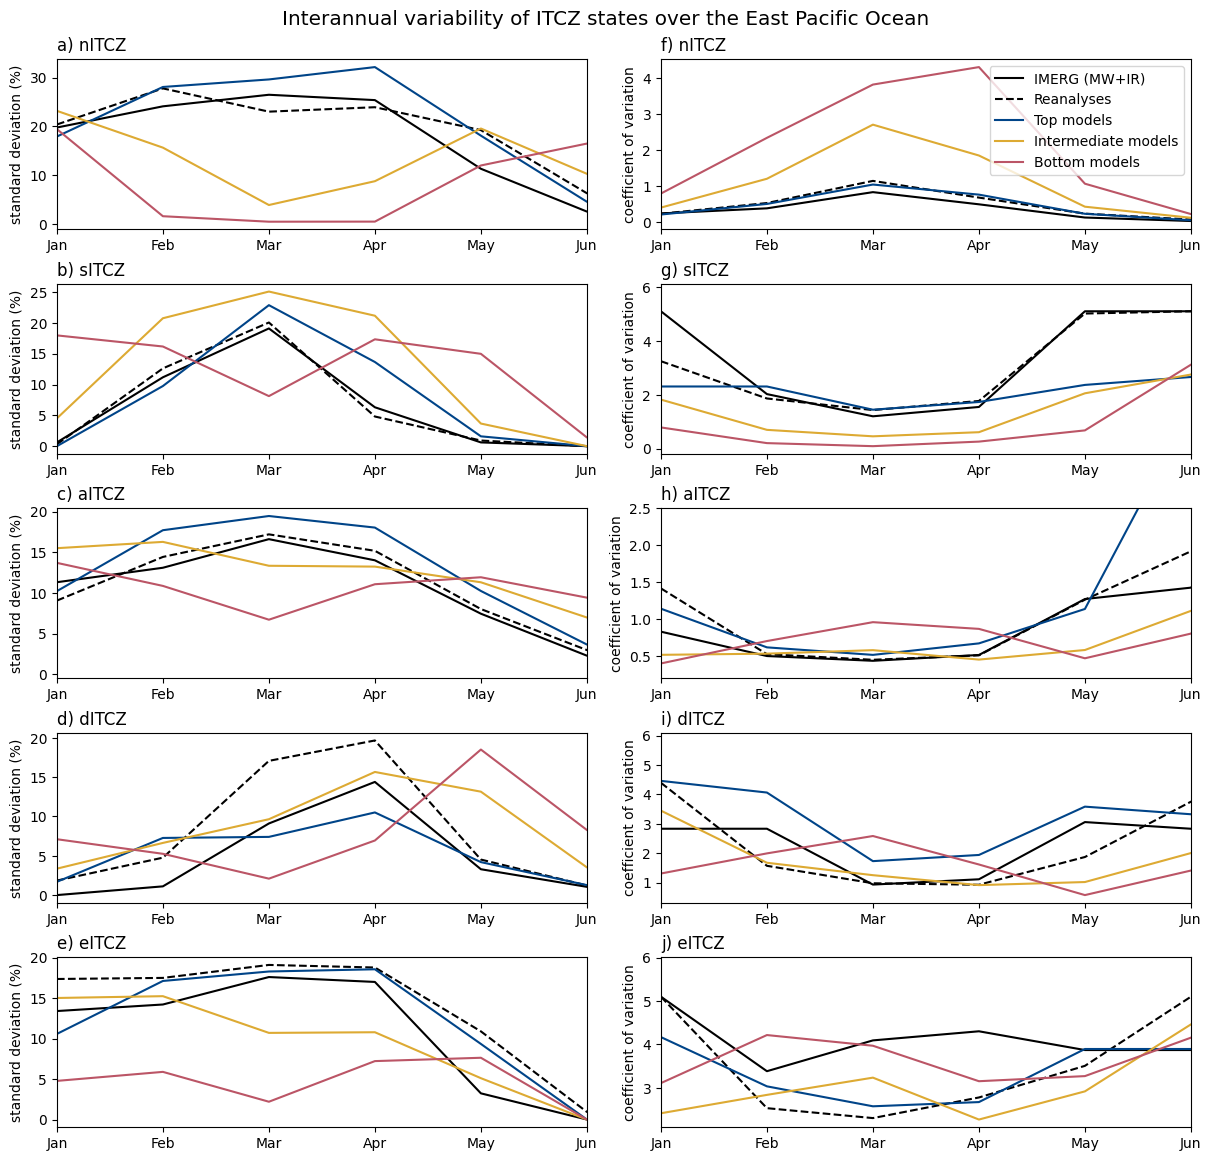

In [46]:
npan = 10

# all of the sizes are double the size they'll be in the paper 
fig = plt.figure(figsize=(12,20), constrained_layout='true')
fig.suptitle(r'Interannual variability of ITCZ states over the '+region_str,fontsize='x-large')
for jj in range(0,npan,1):
    ax = fig.add_subplot(npan,2,jj+1)
    #axs.set_ylim(0,105)

    if jj == 0:
        # plot violin plot
        ax1 = ax.plot(month,data_nI_interannr_xr.sel(dataset='IMERG'),color='k',label='IMERG (MW+IR)')
        ax2 = ax.plot(month,prc_nITCZ_reana,color='k',linestyle='--',label='Reanalyses')
        ax3 = ax.plot(month,data_nI_interann_xr.sel(dataset=group1_xr).median(dim=('dataset')), color='#004488',label=g1_name)
        ax4 = ax.plot(month,data_nI_interann_xr.sel(dataset=group2_xr).median(dim=('dataset')), color='#DDAA33',label=g2_name)
        ax5 = ax.plot(month,data_nI_interann_xr.sel(dataset=group3_xr).median(dim=('dataset')), color='#BB5566',label=g3_name)

        #plt.legend(loc='upper right')
        plt.ylabel('standard deviation (%)')
        #plt.ylim(-3,37)
        ax.set_title('a) nITCZ', loc='left')
    if jj == 2:
        # plot violin plot
        ax1 = ax.plot(month,data_sI_interannr_xr.sel(dataset='IMERG'),color='k',label='IMERG (MW+IR)')
        ax2 = ax.plot(month,prc_sITCZ_reana,color='k',linestyle='--',label='Reanalysis')
        ax3 = ax.plot(month,data_sI_interann_xr.sel(dataset=group1_xr).median(dim=('dataset')), color='#004488',label=g1_name)
        ax4 = ax.plot(month,data_sI_interann_xr.sel(dataset=group2_xr).median(dim=('dataset')), color='#DDAA33',label=g2_name)
        ax5 = ax.plot(month,data_sI_interann_xr.sel(dataset=group3_xr).median(dim=('dataset')), color='#BB5566',label=g3_name)

        #plt.legend(loc='upper right')
        plt.ylabel('standard deviation (%)')
        #plt.ylim(-3,37)
        ax.set_title('b) sITCZ', loc='left')
    if jj == 4:
        # plot violin plot
        ax1 = ax.plot(month,data_aI_interannr_xr.sel(dataset='IMERG'),color='k',label='IMERG (MW+IR)')
        ax2 = ax.plot(month,prc_aITCZ_reana,color='k',linestyle='--',label='Reanalysis')
        ax3 = ax.plot(month,data_aI_interann_xr.sel(dataset=group1_xr).median(dim=('dataset')), color='#004488',label=g1_name)
        ax4 = ax.plot(month,data_aI_interann_xr.sel(dataset=group2_xr).median(dim=('dataset')), color='#DDAA33',label=g2_name)
        ax5 = ax.plot(month,data_aI_interann_xr.sel(dataset=group3_xr).median(dim=('dataset')), color='#BB5566',label=g3_name)

        #plt.legend(loc='upper right')
        plt.ylabel('standard deviation (%)')
        ax.set_title('c) aITCZ', loc='left')    
    if jj == 6:
        # plot violin plot
        ax1 = ax.plot(month,data_dI_interannr_xr.sel(dataset='IMERG'),color='k',label='IMERG (MW+IR)')
        ax2 = ax.plot(month,prc_dITCZ_reana,color='k',linestyle='--',label='Reanalysis')
        ax3 = ax.plot(month,data_dI_interann_xr.sel(dataset=group1_xr).median(dim=('dataset')), color='#004488',label=g1_name)
        ax4 = ax.plot(month,data_dI_interann_xr.sel(dataset=group2_xr).median(dim=('dataset')), color='#DDAA33',label=g2_name)
        ax5 = ax.plot(month,data_dI_interann_xr.sel(dataset=group3_xr).median(dim=('dataset')), color='#BB5566',label=g3_name)

        #plt.legend(loc='upper right')
        plt.ylabel('standard deviation (%)')
        #plt.ylim(-3,37)
        ax.set_title('d) dITCZ', loc='left')
    if jj == 8:
        # plot violin plot
        ax1 = ax.plot(month,data_eI_interannr_xr.sel(dataset='IMERG'),color='k',label='IMERG (MW+IR)')
        ax2 = ax.plot(month,prc_eITCZ_reana,color='k',linestyle='--',label='Reanalysis')
        ax3 = ax.plot(month,data_eI_interann_xr.sel(dataset=group1_xr).median(dim=('dataset')), color='#004488',label=g1_name)
        ax4 = ax.plot(month,data_eI_interann_xr.sel(dataset=group2_xr).median(dim=('dataset')), color='#DDAA33',label=g2_name)
        ax5 = ax.plot(month,data_eI_interann_xr.sel(dataset=group3_xr).median(dim=('dataset')), color='#BB5566',label=g3_name)

        #plt.legend(loc='upper right')
        plt.ylabel('standard deviation (%)')
        #plt.ylim(-3,37)
        ax.set_title('e) eITCZ', loc='left')

    if jj == 1:
        # plot violin plot
        ax1 = ax.plot(month,data_nI_cv_final_r.sel(dataset='IMERG'),color='k',label='IMERG (MW+IR)')
        ax2 = ax.plot(month,prc_nITCZ_reana_cv,color='k',linestyle='--',label='Reanalyses')
        ax3 = ax.plot(month,data_nI_cv_final.sel(dataset=group1_xr).median(dim=('dataset')), color='#004488',label=g1_name)
        ax4 = ax.plot(month,data_nI_cv_final.sel(dataset=group2_xr).median(dim=('dataset')), color='#DDAA33',label=g2_name)
        ax5 = ax.plot(month,data_nI_cv_final.sel(dataset=group3_xr).median(dim=('dataset')), color='#BB5566',label=g3_name)

        plt.legend(loc='upper right')
        plt.ylabel('coefficient of variation')
        #plt.ylim(-3,37)
        ax.set_title('f) nITCZ', loc='left')
    if jj == 3:
        # plot violin plot
        ax1 = ax.plot(month,data_sI_cv_final_r.sel(dataset='IMERG'),color='k',label='IMERG (MW+IR)')
        ax2 = ax.plot(month,prc_sITCZ_reana_cv,color='k',linestyle='--',label='Reanalysis')
        ax3 = ax.plot(month,data_sI_cv_final.sel(dataset=group1_xr).median(dim=('dataset')), color='#004488',label=g1_name)
        ax4 = ax.plot(month,data_sI_cv_final.sel(dataset=group2_xr).median(dim=('dataset')), color='#DDAA33',label=g2_name)
        ax5 = ax.plot(month,data_sI_cv_final.sel(dataset=group3_xr).median(dim=('dataset')), color='#BB5566',label=g3_name)

        #plt.legend(loc='upper right')
        plt.ylabel('coefficient of variation')
        #plt.ylim(-3,37)
        ax.set_title('g) sITCZ', loc='left')
    if jj == 5:
        # plot violin plot
        ax1 = ax.plot(month,data_aI_cv_final_r.sel(dataset='IMERG'),color='k',label='IMERG (MW+IR)')
        ax2 = ax.plot(month,prc_aITCZ_reana_cv,color='k',linestyle='--',label='Reanalysis')
        ax3 = ax.plot(month,data_aI_cv_final.sel(dataset=group1_xr).median(dim=('dataset')), color='#004488',label=g1_name)
        ax4 = ax.plot(month,data_aI_cv_final.sel(dataset=group2_xr).median(dim=('dataset')), color='#DDAA33',label=g2_name)
        ax5 = ax.plot(month,data_aI_cv_final.sel(dataset=group3_xr).median(dim=('dataset')), color='#BB5566',label=g3_name)

        #plt.legend(loc='upper right')
        plt.ylabel('coefficient of variation')
        plt.ylim(.2,2.5)
        ax.set_title('h) aITCZ', loc='left')    
    if jj == 7:
        # plot violin plot
        ax1 = ax.plot(month,data_dI_cv_final_r.sel(dataset='IMERG'),color='k',label='IMERG (MW+IR)')
        ax2 = ax.plot(month,prc_dITCZ_reana_cv,color='k',linestyle='--',label='Reanalysis')
        ax3 = ax.plot(month,data_dI_cv_final.sel(dataset=group1_xr).median(dim=('dataset')), color='#004488',label=g1_name)
        ax4 = ax.plot(month,data_dI_cv_final.sel(dataset=group2_xr).median(dim=('dataset')), color='#DDAA33',label=g2_name)
        ax5 = ax.plot(month,data_dI_cv_final.sel(dataset=group3_xr).median(dim=('dataset')), color='#BB5566',label=g3_name)

        #plt.legend(loc='upper right')
        plt.ylabel('coefficient of variation')
        #plt.ylim(-3,37)
        ax.set_title('i) dITCZ', loc='left')
    if jj == 9:
        # plot violin plot
        ax1 = ax.plot(month,data_eI_cv_final_r.sel(dataset='IMERG'),color='k',label='IMERG (MW+IR)')
        ax2 = ax.plot(month,prc_eITCZ_reana_cv,color='k',linestyle='--',label='Reanalysis')
        ax3 = ax.plot(month,data_eI_cv_final.sel(dataset=group1_xr).median(dim=('dataset')), color='#004488',label=g1_name)
        ax4 = ax.plot(month,data_eI_cv_final.sel(dataset=group2_xr).median(dim=('dataset')), color='#DDAA33',label=g2_name)
        ax5 = ax.plot(month,data_eI_cv_final.sel(dataset=group3_xr).median(dim=('dataset')), color='#BB5566',label=g3_name)

        #plt.legend(loc='upper right')
        plt.ylabel('coefficient of variation')
        #plt.ylim(-3,37)
        ax.set_title('j) eITCZ', loc='left')
    #ax.set_title('Jan-May mean error = '+str(prc_anom_abs_median_fmt[jj])+'%', loc='right')
    plt.xlim(1,6)
    #plt.xlabel('month')
    ax.set_xticks(month[:6],labels=mon_str[:6])
    
#plt.savefig(figfolder+figname,bbox_inches="tight",transparent=False,dpi=150)